In [13]:
import folium
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

from collections import defaultdict
from math import pi, cos
from dataclasses import dataclass
from loguru import logger

from plot import ecdf
from geogiant.common.files_utils import load_json, load_pickle, load_csv
from geogiant.common.ip_addresses_utils import get_prefix_from_ip
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()


@dataclass(frozen=True)
class ResultsScore:
    client_granularity: str
    answer_granularity: str
    scores: list
    inconsistent_mappings: list


targets = load_json(path_settings.OLD_TARGETS)
targets_coordinates = {}
for target in targets:
    if "country_code" in target:
        targets_coordinates[target["address_v4"]] = {
            "lat": target["geometry"]["coordinates"][1],
            "lon": target["geometry"]["coordinates"][0],
            "country_code": target["country_code"],
        }
    else:
        logger.info(f"Missing country code for target: {target['address_v4']}")

vps = load_json(path_settings.OLD_VPS)
vps_coordinates = {}
vps_per_subnet = defaultdict(list)
for vp in vps:
    vps_coordinates[vp["address_v4"]] = {
        "lat": vp["geometry"]["coordinates"][1],
        "lon": vp["geometry"]["coordinates"][0],
        "country_code": vp["country_code"],
    }

    subnet = get_prefix_from_ip(vp["address_v4"])
    vps_per_subnet[subnet].append(vp["address_v4"])


def plotDot(lat, lon, map, color="blue"):
    """input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map"""
    folium.CircleMarker(location=[lat, lon], radius=2, weight=5, color=color).add_to(
        map
    )


def find_exterior_points(points):
    # Create a numpy array from the list of points
    points_array = np.array(points)

    # Compute the convex hull
    hull = ConvexHull(points_array)

    # Extract the indices of exterior points
    exterior_indices = hull.vertices

    # Get the exterior points
    exterior_points = points_array[exterior_indices]

    return exterior_points, hull


def get_median_dist_error(target_results: dict, key: str) -> float:
    """return the median distance error"""
    return round(
        np.median([r[key]["d_error"] for r in target_results.values()]),
        2,
    )

In [14]:
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / "evaluation_1M_hostnames_answer_bgp_prefix_max_bgp_prefix_clusters.pickle"
)

In [15]:
answer_granularity = "answer_bgp_prefix"
results = eval_results[answer_granularity]

no_ping_m_d = get_median_dist_error(results, "no_ping_vp")
ecs_cluster_shortest_ping_m_d = get_median_dist_error(
    results, "ecs_cluster_shortest_ping_vp"
)
# no_ping_cluster_m_d = get_median_dist_error(results, "no_ping_cluster_vp")

logger.info(f"No ping:: median_error={round(no_ping_m_d, 2)} [km]")
logger.info(
    f"ECS  cluster shortest ping:: median_error={round(ecs_cluster_shortest_ping_m_d, 2)} [km]"
)
# logger.info(f"No ping cluster:: median_error={round(no_ping_cluster_m_d, 2)} [km]")

2024-03-13 10:28:39.760 | INFO     | __main__:<module>:10 - No ping:: median_error=49.88 [km]
2024-03-13 10:28:39.761 | INFO     | __main__:<module>:11 - ECS  cluster shortest ping:: median_error=11.83 [km]


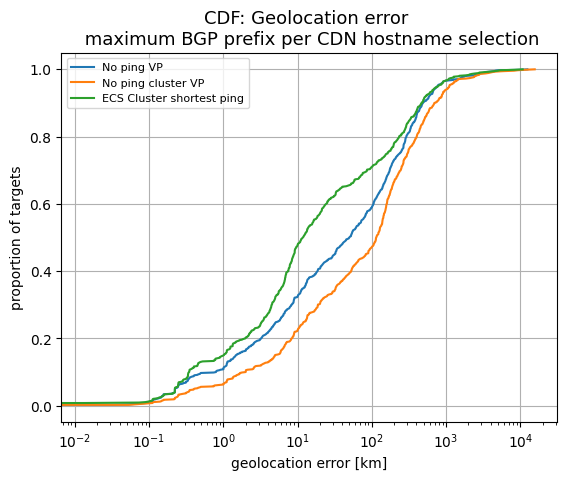

In [16]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([r["no_ping_vp"]["d_error"] for r in results.values()])
ax1.plot(x, y, label=f"No ping VP")

x, y = ecdf([r["no_ping_cluster_vp"]["d_error"] for r in results.values()])
ax1.plot(x, y, label=f"No ping cluster VP")

x, y = ecdf([r["ecs_cluster_shortest_ping_vp"]["d_error"] for r in results.values()])

ax1.plot(x, y, label=f"ECS Cluster shortest ping")
plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

2024-03-13 10:28:40.394 | INFO     | __main__:<module>:20 - Avg Measurement cost cluster selection = 17.39
2024-03-13 10:28:40.396 | INFO     | __main__:<module>:21 - Median Measurement cost cluster selection = 17.0


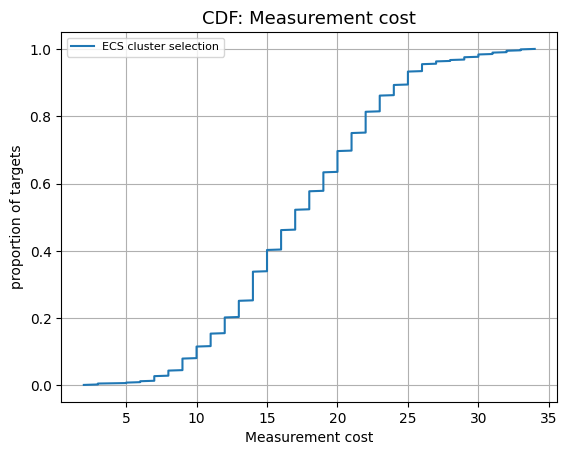

In [17]:
granularity = "answer_bgp_prefix"
results = eval_results[granularity]

fig, ax1 = plt.subplots(1, 1)


x, y = ecdf([len(r["filtered_vps_per_cluster"]) for r in results.values()])
ax1.plot(x, y, label="ECS cluster selection")

avg_cost_cluster = round(
    np.mean([[len(r["filtered_vps_per_cluster"]) for r in results.values()]]),
    2,
)
median_cost_cluster = round(
    np.median([[len(r["filtered_vps_per_cluster"]) for r in results.values()]]),
    2,
)


logger.info(f"Avg Measurement cost cluster selection = {avg_cost_cluster}")
logger.info(f"Median Measurement cost cluster selection = {median_cost_cluster}")

plt.xlabel("Measurement cost")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.grid()
plt.title(
    f"CDF: Measurement cost",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "measurement_cost_cluster_selection.pdf")
plt.show()